# **Facial Keypoints Detection**
# **Final Submission Notebook**

### **By: Hannah Gross, Anand Patel, Frances Leung & Rumi Nakagawa**

***

# Final CNN Model

***
### Notebook Summary
Sections 1-4 will instantiate functions that will prepare data for our models.
Section 5 will build and evaluate a new model based on the Semi-Supervised Data generated in [this notebook](https://drive.google.com/file/d/1VLXekUkKQglZ8heA56lzpYvSNstLlc4u/view?usp=sharing). 
Section 6 will load in the best model we created and evaluate it against our [original Semi-Supervised Data](https://drive.google.com/drive/folders/1ofofejGA8chR4M3PRvLhNujZFYa1X6di?usp=sharing).
***
### Data Information
##### [Link to Kaggle Dataset](https://www.kaggle.com/c/facial-keypoints-detection)
- The model built in Section 5 is trained and evaluated on Semi-Supervised Data and augmented "perfect" data. Semi-Supervised Data is a copy of the original Kaggle data but uses specialized CNN models to fill in missing keypoint values. This data was and can be generated in [this notebook](https://colab.research.google.com/drive/1ObcS5B9m05gmHp10JagCoqIfRXjT3WjV?usp=sharing). "Perfect" data means observations with no missing keypoint coordinate values. This data was sourced from the original dataset as it includes NaN values.
- The model loaded in Section 6 is evaluated on the first version of our Semi-Supervised Data. This version of Semi-Supervised Data was made with the same preprocessing and model structure as what is in the previously linked notebook.
- Both Semi-Supervised, Originial Semi-Supervised and original Kaggle data are split into training, dev and test segments detailed below:
    * `dev_data` (100 examples): evaluation data left out of training. It can include "perfect" data and filled in data from Kaggle's original raw data. Measures how well our model generalizes to data it has not seen that is similar to its training data.
    * `test_data` (1049 examples): validation data used in the model's `.fit()` function to save out the best generalizing model by the validation metric.
    * `perf_eval_data` (381 examples): evaluation data left out of training. Composed of perfect data extracted from `test_data` and `dev_data`. Measures how well our model generalizes to data "perfect" data that it has not seen.

***
### CNN Model Build Information
The CNN Model is built in two training phases. Phase 1 utilizes 256 epochs and has a batch size of 8. This produces a more incremental, or bumpy descent, to hopefully move towards the global minimum. The small mini-batch size, combined with the long training session, will give the model opportunities to jump out of local minima. It looks to minimize the **validation data root mean square error**, Kaggle's evaluation metric for this competition. Phase 2 retrains the previous model, again aiming to minimize the **validation root mean square error**. It uses only 10 epochs with a batch size of 512. This causes the model to descend towards a close by local minimum. The rationale for this structure, is that the first phase will help the model locate the global minimum. Once located, the second phase of the model will allow it to smoothly descend towards that global minimum.

*Additional Notes:*
- Trained on Semi-Supervised Training Data (5900 examples) and augmented (rotated) "perfect" observations sourced from the original dataset (3518 examples). Total of 9418 examples.
- Validating each epoch on Semi-Supervised Test Data (1049 examples).
- Evaluating model on Semi-Supervised Dev Data, Semi-Supervised Test Data & concatenated "perfect" test and dev data.
- Loss Function: Mean Squared Error
- Score Metrics: Mean Absolute Error, Accuracy & Root Mean Squared Error
***
### Retrained CNN Model Results (Section 5)
*Please note these results are subject to change if the notebook is rerun in full.*

**`sup_dev_data`** (100 examples): loss: 1.1887 - mae: 0.7286 - accuracy: 0.8100 - root_mean_squared_error: 1.0903

**`sup_test_data`** (1049 examples): loss: 2.1366 - mae: 0.7309 - accuracy: 0.7969 - root_mean_squared_error: 1.4617 

**`perf_eval_data`** (381 examples): loss: 0.3023 - mae: 0.2754 - accuracy: 0.9738 - root_mean_squared_error: 0.5498

***
### Best CNN Model Results (Section 6)
*Please note these results should not change.*

**`og_sup_dev_data`** (100 examples): loss: 0.2772 - mae: 0.3202 - accuracy: 0.9400 - root_mean_squared_error: 0.5265

**`og_sup_test_data`** (1049 examples): loss: 1.0100 - mae: 0.3572 - accuracy: 0.9161 - root_mean_squared_error: 1.0050

**`perf_eval_data`** (381 examples): loss: 0.3213 - mae: 0.3370 - accuracy: 0.9633 - root_mean_squared_error: 0.5669

***

## Section 1: Import Dependencies and Data.
1. Mount drive. 
2. Import EDA and model dependencies.
3. Import original & semi-supervised training data and Kaggle test data.

In [ ]:
## 1.1 Mount drive.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
## 1.2 Import EDA and model dependencies.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sin, cos, pi
from skimage import data, img_as_float, exposure

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D, MaxPool2D, ZeroPadding2D, ELU
from keras.metrics import RootMeanSquaredError as RMSE
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array 
from tensorflow.keras.callbacks import ModelCheckpoint

# Set the randomizer seeds so results are reproducable.
np.random.seed(20)
tf.random.set_seed(42)

%matplotlib inline

In [ ]:
## 1.3 Import original & semi-supervised training data and Kaggle test data.
# Import data from google drive.
og_data_dir = "./_facial_keypoint_detection/Kaggle_Data/training.csv"
sup_data_dir = "./_facial_keypoint_detection/Semi-Supervised_Learning/Semi-Supervised_Data/sup_training_data_model_15.csv"
test_dir = "./_facial_keypoint_detection/Kaggle_Data/test.csv"
# Input data into pandas dataframe obj. 
og_raw_training_data = pd.read_csv(og_data_dir)
sup_raw_training_data = pd.read_csv(sup_data_dir)
final_test_data = pd.read_csv(test_dir)

## Section 2: Segment and Preprocess Data.

1. Build preprocessor functions to separate input and output variables from the imported datasets. 
2. Create segmentation function to preprocess and segment data into test, dev and training sets. 
3. Apply segmentation function to original and semisupervised datasets and preprocess final Kaggle test data. The same split is applied to these two datasets to ensure the same samples end up in test, dev, and training sets.

In [ ]:
## 2.1 Build preprocessor functions to separate input and output variables from 
#      the imported datasets.
def str_splitter_img(img_str):
  """
  Purpose: Takes the string of pixel values for each observation and converts 
  the string into a numpy array of floats. If a pixel value is missing, replaces 
  the missing value with 0.

  Output: img: list of cleaned pixel values.
  """
  img = img_str.split()
  img = ["0" if x == "" else x for x in img]
  return img

def load_images(image_data):
  """
  Purpose: Takes dataframe with Image column and transforms image values into a 
  96x96x1 numpy array of float values between 0 and 1. Please note, the extra 
  dimension is for TF models.

  Output: images: 96x96x1 numpy array of image pixels. 
  """
  images = []
  for idx, sample in image_data.iterrows():
      image = np.array(str_splitter_img(sample["Image"]), dtype=int)
      image = np.reshape(image, (96,96,1))
      images.append(image)
  images = np.array(images)/255
  return images

def load_keypoints(df):
  """
  Purpose: Takes a dataframe with keypoints columns and convert them into float 
  numpy array of keypoints

  Output: keypoint_features: float numpy array of keypoints. Each example is 
  (30,) array of floats. 
  """
  keypoint_features = df.iloc[:,:-1].values
  return keypoint_features
  
def preprocessor(df):
  """
  Purpose: Takes a dataframe of raw data and separates the input (image pixel 
  values) from the output (facial keypoint values). The function also controls 
  all the transformations applied to these segments of data.

  Output: tuple of transformed output (X) and input (Y).
  """
  # 1. Convert training data string of floats into a float numpy array and 
  #    transform each float into a value between 0 and 1.
  X = load_images(df)

  # 2. Convert training labels into a float numpy array.  
  Y = load_keypoints(df)
  return X, Y


In [ ]:
## 2.2 Create segmentation function to preprocess and segment data into test, 
#      dev and training sets.
def segment_data(data):
  """
  Purpose: Takes full raw data in pandas dataframe and preprocesses data into 
  cleaned input and output numpy arrays.

  Output: Segmented data and labels into test, dev and training splits.
  """
  # Preprocess data.
  X, Y = preprocessor(data)

  # Shuffle data. 
  shuffle = np.random.permutation(np.arange(X.shape[0]))
  X, Y = X[shuffle], Y[shuffle]

  print("data shape:", X.shape)
  print("label shape:", Y.shape)

  # Set variables to hold test, dev, and training data.
  test_data, test_labels = X[6000:], Y[6000:] # 1049/7049 samples
  dev_data, dev_labels = X[5900:6000], Y[5900:6000] # 100/7049 samples
  train_data, train_labels = X[:5900], Y[:5900] # 5900/7049 samples
 
  return test_data, test_labels, dev_data, dev_labels, train_data, train_labels

In [ ]:
## 2.3 Apply segmentation function to original and Semi-Supervised datasets and 
#      preprocess final Kaggle test data.

# Split and preprocess original training data.
print("Original Data & Labels:")
og_test_data, og_test_labels, \
og_dev_data, og_dev_labels, \
og_train_data, og_train_labels = segment_data(og_raw_training_data)

# Split and preprocess Semi-Supervised training data.
print("\nSemi-Supervised Data & Labels:")
sup_test_data, sup_test_labels, \
sup_dev_data, sup_dev_labels, \
sup_train_data, sup_train_labels = segment_data(sup_raw_training_data)

# Preprocess test data.
X_test_final = load_images(final_test_data)

Original Data & Labels:
data shape: (7049, 96, 96, 1)
label shape: (7049, 30)

Semi-Supervised Data & Labels:
data shape: (7049, 96, 96, 1)
label shape: (7049, 30)


## Section 3: Data Augmentation. 

In this section we will create new augmented data from "perfect" observations in our original training data set. "Perfect" observations are data entries that have no missing facial keypoint values. We will use the original training set to identify these observations. This because the original set includes NaN values, as opposed to the Semi-Supervised set where NaN values have been replaced by estimated values. 

1. Get a count of NaN values in each facial keypoint. 
2. Make function to identify & remove observations with NaN keypoint values.
3. Build augmentation function to rotate images. 
4. Isolate perfect observations from original training set and apply rotation function and append new augmented data to semi-supervised training data.
5. Isolate perfect observations from original test and dev sets and concatenate to form a perfect evaluation dataset.

In [ ]:
## 3.1 Get a count of NaN values in each facial keypoint. 
# Remove image variable from og_raw_training_data.
cols = og_raw_training_data.columns[:-1]
og_train_labels_df = pd.DataFrame(og_train_labels, columns=cols)

# Count all NaN values in each variable.
nan_keypoints = pd.DataFrame(og_train_labels_df.isna().sum())

# Nicely format dataframe.
nan_keypoints.index.names = ["Facial Keypoints"]
nan_keypoints.columns = ["NaN Count"]

# Show dataframe.
nan_keypoints

,NaN Count
Facial Keypoints,
left_eye_center_x,9
left_eye_center_y,9
right_eye_center_x,11
right_eye_center_y,11
left_eye_inner_corner_x,4031
left_eye_inner_corner_y,4031
left_eye_outer_corner_x,4038
left_eye_outer_corner_y,4038
right_eye_inner_corner_x,4034


In [ ]:
## 3.2 Make function to identify & remove observations with NaN keypoint values.
def remove_nan_obsv(X, Y):
  """
  Purpose: Takes input and output numpy arrays and removes all observations with 
  a NaN in the output data. 

  Output: Input and output numpy arrays with only observations with complete 
  output values.
  """
  # Create function to remove training examples with a NaN in the output data.
  id_perfect_observations = lambda y: True if (sum(np.isnan(y))==0) else False

  # Loop through data and labels to build list of perfect observations.
  perf_data = []
  perf_labels = []
  for x, y in zip(X, Y):
    if id_perfect_observations(y)==True:
      perf_data.append(x)
      perf_labels.append(y)

  # Convert lists of perfect observations into numpy arrays.
  perf_data = np.array(perf_data)
  perf_labels = np.array(perf_labels)

  # Report data shapes.
  print("perfect data shape:", perf_data.shape)
  print("perfect labels shape:", perf_labels.shape)

  nan_count = np.isnan(perf_labels).sum()
  print("There are %.0f NaN values in perfect_labels" % (nan_count))
  return perf_data, perf_labels

In [ ]:
## 3.3 Build augmentation function to rotate images.

def rotate_images(img, degree):
  """
  Purpose: Takes input data numpy array and a degree float object. Function will
  rotate the image data to the degree specified.

  Output: Rotated image to the degree specified.
  """
  # Create a new ImageDataGenerator object.
  datagen = ImageDataGenerator()

  # Rotate image.
  X_rotated_3D = datagen.apply_transform(x=img, # input is 3d
                                         transform_parameters={'theta':degree})
  X_rotated_3D = X_rotated_3D*255
  return X_rotated_3D

def rotate_keypt(y, degree):
  """
  Purpose: Takes the set of 30 keypoints from a single observation and a degree 
  float object. Function will rotate the keypoint data to the degree specified.

  Output: Rotated keypoints to the degree specified.
  """
  # Define zero array for new rotated values to be stored when center of the 
  # rotation is moved to (0,0).
  rotated_keypt_origin = np.zeros(y.shape)

  # Obtain angle in radians from angle in degrees (notice negative sign for 
  # change in clockwise vs anti-clockwise directions from conventional rotation 
  # to cv2's image rotation).
  angle_rad = degree*pi/180. 

  # Move coordinates to origin to apply rotation.
  # 48 is half of 96, the image's height/width
  keypt_origin = y - 48.

  # Rotate both x and y keypoints.
  for i in range(0,30,2):
    rotated_keypt_origin[i] = keypt_origin[i]*cos(angle_rad)-\
    keypt_origin[i+1]*sin(angle_rad) 

    rotated_keypt_origin[i+1] = keypt_origin[i]*sin(angle_rad)+\
    keypt_origin[i+1]*cos(angle_rad)
  y_rotated = rotated_keypt_origin + 48. 
  return y_rotated

def rotate_data(X, Y):
  """
  Purpose: Takes both input and output data arrays and applies the rotation 
  functions above. This function will create two sets of rotated images. One 
  set that is rotated slightly to the left and another rotated to the right. The
  degree of rotation is determined by selecting a random float from a uniform 
  distribution.

  Output: Rotated input and output data.
  """
  # Create zero array and assign new image data.
  left_X_rotated = np.zeros(X.shape)
  left_Y_rotated = np.zeros(Y.shape)

  right_X_rotated = np.zeros(X.shape)
  right_Y_rotated = np.zeros(Y.shape)

  # Loop through each observation in dataset.
  for i in range(X.shape[0]):
    # Choose a random left and right degree from a uniform distribution.
    right_degree = np.random.uniform(1,16) # 1 degree to 16 degrees
    left_degree = np.random.uniform(345,359) # -1 degree to -15 degrees

    # Apply rotation functions.
    left_X_rotated[i] = rotate_images(X[i],left_degree).astype("uint8")
    left_Y_rotated[i] = rotate_keypt(Y[i], left_degree)
    right_X_rotated[i] = rotate_images(X[i],right_degree).astype("uint8")
    right_Y_rotated[i] = rotate_keypt(Y[i], right_degree)

  # Append right and left rotated data into a numpy array.
  X_rotated = np.array(list(left_X_rotated) + list(right_X_rotated))
  Y_rotated = np.array(list(left_Y_rotated) + list(right_Y_rotated))
  return X_rotated, Y_rotated

def get_image_and_dots(index, 
                       image_ar, 
                       keypoints_ar=np.array([]), 
                       predictions_ar=np.array([])):
  """
  Purpose: Prints an image and keypoints from feature, label and prediction 
  arrays using an index. Label and prediction printing hard-coded to print from 
  all 30 keypoints available. Prediction printing is optional.

  Output: l: a face image with label and predicted keypoints plotted.
  """
  face = np.reshape(image_ar[index], (96, 96)) # Reshape face pixels.
  image = plt.imshow(face[::-1], cmap="gray", origin="lower") # Make face image.

  l = []
  l2 = []
  # Append label keypoints for each face.
  for i in range(1,31,2):
    if len(keypoints_ar) > 0:
      l.append(plt.plot(keypoints_ar[index][i-1], 
                        96-keypoints_ar[index][i], 
                        "bo", markersize=4))

    if len(predictions_ar) > 0:
      # Append prediction predictions for each face.
      l2.append(plt.plot(predictions_ar[index][i-1], 
                         96-predictions_ar[index][i],
                         marker="o", 
                         markersize=4, 
                         markeredgecolor = "r", 
                         fillstyle=None, 
                         color = "r"))  
  return l, l2

def show_augmented_image_keypt(X, Y, X_rotated, Y_rotated, num_to_show=4):
  """
  Purpose: Takes both input and output data arrays and rotated input and output
  arrays and prints the original and rotated images side by side with keypoints.

  Output: None.
  """
  # Create new figure.
  fig = plt.figure(figsize=(8,16))

  # Compare original images + keypoints with flipped ones.
  img_counter = 0
  for i in range(1,8,2):
    # Plot original image.
    plt.subplot(num_to_show,2,i)
    plt.title("Original Image & Keypoints", size=12, weight="bold")
    get_image_and_dots(img_counter, X, keypoints_ar=Y)

    # Plot rotated image.
    plt.subplot(num_to_show,2,i+1)
    get_image_and_dots(img_counter, X_rotated, predictions_ar=Y_rotated)
    plt.title("Rotated Image & Keypoints", size=12, weight="bold")
    img_counter += 1
  plt.show()
  return None


For Original Train Data:
perfect data shape: (1759, 96, 96, 1)
perfect labels shape: (1759, 30)
There are 0 NaN values in perfect_labels


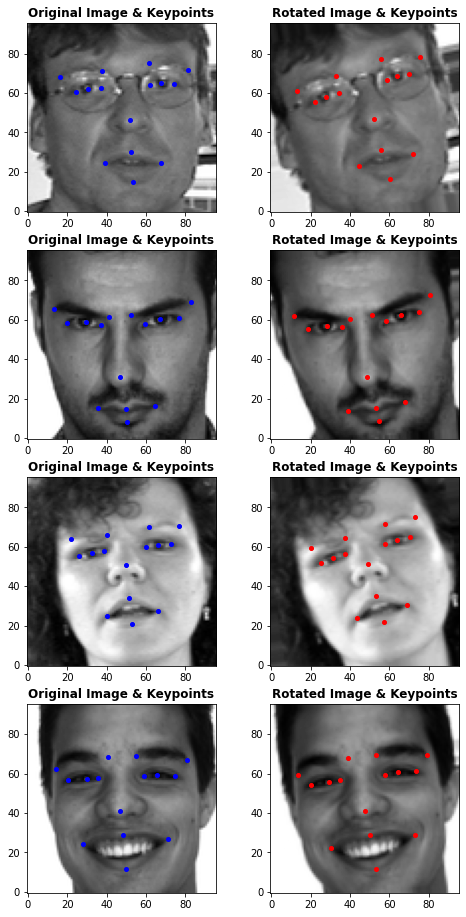


Concatenate sup_train_data & X_rotated to aug_train_data
sup_train_data: (5900, 96, 96, 1)
X_rotated (15 degrees): (3518, 96, 96, 1)
aug_train_data: (9418, 96, 96, 1)

Concatenate sup_train_labels & Y_rotated to aug_train_labels
sup_train_labels: (5900, 30)
Y_rotated: (3518, 30)
aug_train_labels: (9418, 30)


In [ ]:
## 3.4 Isolate perfect observations from original perfect training set and apply 
#      rotation function and append new augmented data to semi-supervised 
#      training data.

# Extract perfect observations.
print("For Original Train Data:")
perf_train_data, perf_train_labels = remove_nan_obsv(og_train_data, 
                                                     og_train_labels)

# Rotate perfect observations.
X_rotated, Y_rotated = rotate_data(perf_train_data, perf_train_labels)
show_augmented_image_keypt(perf_train_data, perf_train_labels, 
                           X_rotated, Y_rotated)

# Concatenate our sup_train_data & X_rotated.
aug_train_data = np.array(list(sup_train_data) + list(X_rotated))
print("\nConcatenate sup_train_data & X_rotated to aug_train_data")
print("sup_train_data:", sup_train_data.shape)
print("X_rotated (15 degrees):", X_rotated.shape)
print("aug_train_data:", aug_train_data.shape)

# Concatenate our sup_train_labels & Y_rotated.
aug_train_labels = np.array(list(sup_train_labels) + list(Y_rotated))
print("\nConcatenate sup_train_labels & Y_rotated to aug_train_labels")
print("sup_train_labels:", sup_train_labels.shape)
print("Y_rotated:", Y_rotated.shape)
print("aug_train_labels:", aug_train_labels.shape)


In [ ]:
## 3.5 Isolate perfect observations from original test and dev sets and 
#      concatenate to form a perfect evaluation dataset.

# Extract perfect observations.
print("For Original Dev Data:")
perf_dev_data, perf_dev_labels = remove_nan_obsv(og_dev_data, 
                                                 og_dev_labels)

print("\nFor Original Test Data:")
perf_test_data, perf_test_labels = remove_nan_obsv(og_test_data, 
                                                   og_test_labels)

# Concatenate our clean_test_data, clean_dev_data.
perf_eval_data = np.array(list(perf_test_data) + list(perf_dev_data))
print("\nConcatenate clean_test_data & clean_dev_data to perf_eval_data")
print("perf_test_data:", perf_test_data.shape)
print("perf_dev_data:", perf_dev_data.shape)
print("perf_eval_data:", perf_eval_data.shape)

# Concatenate our clean_test_labels, clean_dev_labels.
perf_eval_labels = np.array(list(perf_test_labels) + list(perf_dev_labels))
print("\nConcatenate clean_test_labels & clean_dev_labels to perf_eval_labels")
print("perf_test_labels:", perf_test_labels.shape)
print("perf_dev_labels:", perf_dev_labels.shape)
print("perf_eval_labels:", perf_eval_labels.shape)

For Original Dev Data:
perfect data shape: (41, 96, 96, 1)
perfect labels shape: (41, 30)
There are 0 NaN values in perfect_labels

For Original Test Data:
perfect data shape: (340, 96, 96, 1)
perfect labels shape: (340, 30)
There are 0 NaN values in perfect_labels

Concatenate clean_test_data & clean_dev_data to perf_eval_data
perf_test_data: (340, 96, 96, 1)
perf_dev_data: (41, 96, 96, 1)
perf_eval_data: (381, 96, 96, 1)

Concatenate clean_test_labels & clean_dev_labels to perf_eval_labels
perf_test_labels: (340, 30)
perf_dev_labels: (41, 30)
perf_eval_labels: (381, 30)


## Section 4. Create Plotting Functions. 
*These will be used to display model results*

In [ ]:
def plot_epochs(history_obj):
  """
  Purpose: Takes the history object created during the training phase and plots 
  line graphs of changes in mean squared error loss, root mean squared error, 
  accuracy and mean absolute error by epoch.

  Output: None.
  """
  # Create new figure.
  fig = plt.figure(figsize=(28,5))

  # Plot the training and validation loss.
  ax1 = plt.subplot(1,4,1)
  ax1.plot(history_obj.history["loss"])
  ax1.plot(history_obj.history["val_loss"])
  ax1.set_title("Mean Squared Error (MSE) Loss vs. Epochs", 
                size=14, 
                weight="bold", 
                pad=10)
  ax1.set_ylabel("MSE Loss", size=12, labelpad=4)
  ax1.set_xlabel("Epoch", size=12, labelpad=4)
  ax1.legend(["Training Data", "Validation Data"], loc="upper right")

  # Plot the training and validation RMSE.
  ax2 = plt.subplot(1,4,2)
  ax2.plot(history_obj.history["root_mean_squared_error"])
  ax2.plot(history_obj.history["val_root_mean_squared_error"])
  ax2.set_title("Root Mean Squared Error (RMSE) vs. Epochs", 
                size=14, 
                weight="bold", 
                pad=10)
  ax2.set_ylabel("RMSE", size=12, labelpad=4)
  ax2.set_xlabel("Epoch", size=12, labelpad=4)
  ax2.legend(["Training_RMSE", "Validation_RMSE"], loc="upper right")

  # Plot the training and validation accuracy.
  ax3 = plt.subplot(1,4,3)
  ax3.plot(history_obj.history["accuracy"])
  ax3.plot(history_obj.history["val_accuracy"])
  ax3.set_title("Accuracy vs. Epochs", 
                size=14, 
                weight="bold", 
                pad=10)
  ax3.set_ylabel("Accuracy", size=12, labelpad=4)
  ax3.set_xlabel("Epoch", size=12, labelpad=4)
  ax3.legend(["Training_Accuracy", "Validation_accuracy"], loc="upper right")

  # Plot the training and validation mean absolute error accuracy.
  ax4 = plt.subplot(1,4,4)
  ax4.plot(history_obj.history["mae"])
  ax4.plot(history_obj.history["val_mae"])
  ax4.set_title("Mean Absolute Error (MAE) vs. Epochs", 
                size=14, 
                weight='bold', 
                pad=10)
  ax4.set_ylabel("MAE", size=12, labelpad=4)
  ax4.set_xlabel("Epoch", size=12, labelpad=4)
  ax4.legend(["Training_mae", "Validation_mae"], loc="upper right")

In [ ]:
def plot_predictions(data, labels, predictions):
  """
  Purpose: Takes a data, labels and predictions and prints a 1x7 plot.

  Output: None.
  """
  fig = plt.figure(figsize=(28,5)) # Create new figure.
  # Plot 7 images and true & predicted keypoints.
  for i in range(7):
    plt.subplot(1,7,i+1)
    get_image_and_dots(i, data, 
                      keypoints_ar=labels, 
                      predictions_ar=predictions)
  plt.show()
  print("Note: Predicted points are red, and true labels are blue.")


## Section 5. Train Final CNN.
***
### Overview

1. Build CNN Model. 
2. Compile and Fit Model.
3. Load in Best CNN Model Built in Training Phase.
4. Evaluate Best Trained Model.
    * Augmented Supervised Training Data
    * Supervised Dev Data
    * Supervised Test Data
    * Perfect Test and Dev Data
5. Retrain CNN Model.
6. Evaluate Best Retrained Model.
    * Supervised Dev Data
    * Supervised Test Data
    * Perfect Test and Dev Data
7. Generate Predictions for Final Test Data
***
### Training Conditions
#### Initial CNN Model
- Train for 256 epochs, batch size of 8.
- Train on `aug_train_data`, `augtrain_labels` (# of examples = 9418).
- Validate on `sup_test_data` (# of examples = 1049).
- Minimizing val_rmse.

#### Retrained CNN Model
![Image of Yaktocat](https://i.stack.imgur.com/lU3sx.png)
- Train for 300 epochs, batch size of 512.
- Train on `aug_train_data`, `aug_train_labels` (# of examples = 9418).
- Validate on `sup_test_data` (# of examples = 1049).
- Minimizing val_rmse.
***
### Retrained CNN Model Results
*Please note these results are subject to change if the notebook is rerun in full.*

**`sup_dev_data`** (100 examples): loss: 1.1887 - mae: 0.7286 - accuracy: 0.8100 - root_mean_squared_error: 1.0903

**`sup_test_data`** (1049 examples): loss: 2.1366 - mae: 0.7309 - accuracy: 0.7969 - root_mean_squared_error: 1.4617 

**`perf_eval_data`** (381 examples): loss: 0.3023 - mae: 0.2754 - accuracy: 0.9738 - root_mean_squared_error: 0.5498

***

### Note on Loss Function
Using Mean Squared Error (MSE) rather than Root Mean Squared Error (RMSE). Kaggle evaluates models based on the output RMSE, but MSE is commonly used by participants in this kaggle competition. Please note that RMSE is the square root of the MSE, so optimizing for this loss is producing the model that also minimizes RMSE. 


### 5.1 Build CNN Model.

**Additional Notes on Initial CNN Model**
- Sequential model.
- SELU activation function for CNN layers and dense layer.
- 3x3 CNN filter, same padding so representation is not compressed, and no bias.
- Batch normalization.
- Max Pooling of 2x2.
- 10% Dropout at dense layer before predicting.

In [ ]:
model = Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="selu", 
                        padding="same", use_bias=False, 
                        input_shape=(96, 96, 1)))
model.add(BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(96, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())

model.add(layers.Conv2D(96, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())

model.add(layers.Conv2D(512, (3, 3), activation="selu", 
                        padding="same", use_bias=False))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation="selu"))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        288       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9216      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                        

### 5.2 Compile and Fit Model.

In [ ]:
# Define callback function.
checkpoint_path1 = "./drive/MyDrive/Model_15/Saved_Model_15/initial_model_15.hdf5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path1,
                             save_weights_only=False,
                             save_best_only=True,
                             monitor="val_root_mean_squared_error",
                             mode="min",
                             verbose=1)

In [ ]:
# Compile model.
model.compile(optimizer="adam",
              loss="mse", 
              metrics=["mae", "accuracy", RMSE()])

In [ ]:
# Fit model, saving outputs to history object.
history = model.fit(aug_train_data, aug_train_labels, 
          epochs=256, batch_size=8, 
          validation_data=(sup_test_data, sup_test_labels), 
          callbacks=[checkpoint], 
          shuffle=True)

Epoch 1/256
1178/1178 [==============================] - ETA: 0s - loss: 22.6201 - mae: 3.2298 - accuracy: 0.5150 - root_mean_squared_error: 4.7561
Epoch 00001: val_root_mean_squared_error improved from inf to 3.68421, saving model to ./drive/MyDrive/207_final/Model_15/Saved_Model_15/initial_model_15.hdf5
1178/1178 [==============================] - 19s 14ms/step - loss: 22.6201 - mae: 3.2298 - accuracy: 0.5150 - root_mean_squared_error: 4.7561 - val_loss: 13.5734 - val_mae: 2.8122 - val_accuracy: 0.5634 - val_root_mean_squared_error: 3.6842
Epoch 2/256
1177/1178 [============================>.] - ETA: 0s - loss: 8.2474 - mae: 2.1409 - accuracy: 0.6368 - root_mean_squared_error: 2.8718
Epoch 00002: val_root_mean_squared_error improved from 3.68421 to 2.14251, saving model to ./drive/MyDrive/207_final/Model_15/Saved_Model_15/initial_model_15.hdf5
1178/1178 [==============================] - 16s 14ms/step - loss: 8.2475 - mae: 2.1409 - accuracy: 0.6368 - root_mean_squared_error: 2.8718 -

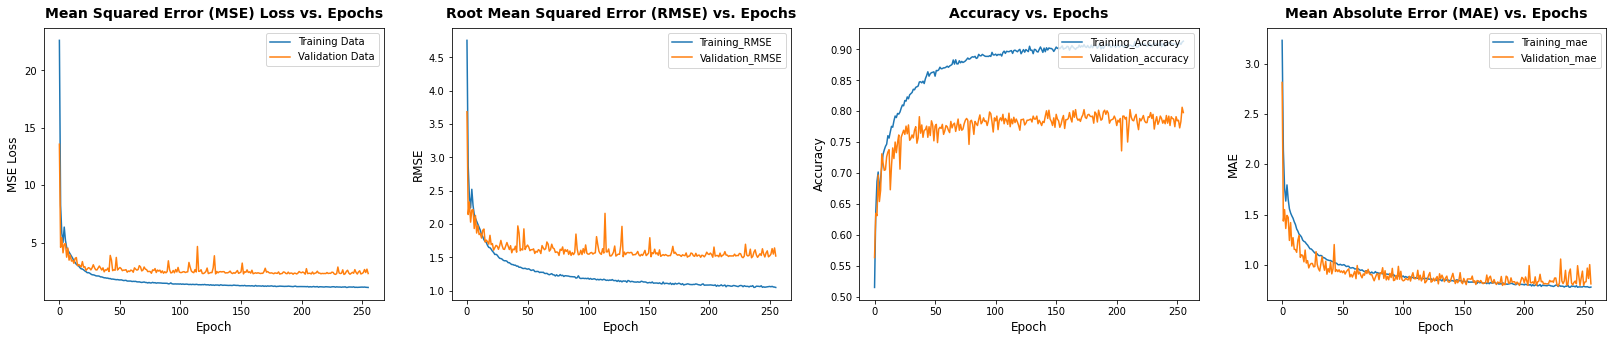

In [ ]:
# Plot metrics for each epoch.
plot_epochs(history)

### 5.3. Load in Best CNN Model Built in Training Phase.

Initial Model Evalutation on Semi-Supervised Dev Data.
4/4 - 0s - loss: 1.4485 - mae: 0.8292 - accuracy: 0.8100 - root_mean_squared_error: 1.2035 - 119ms/epoch - 30ms/step

Mean Absolute Error on Semi-Supervised Dev Data: 0.829
Accuracy on Semi-Supervised Dev Data: 0.810
Root Mean Squared Error on Semi-Supervised Dev Data: 1.204


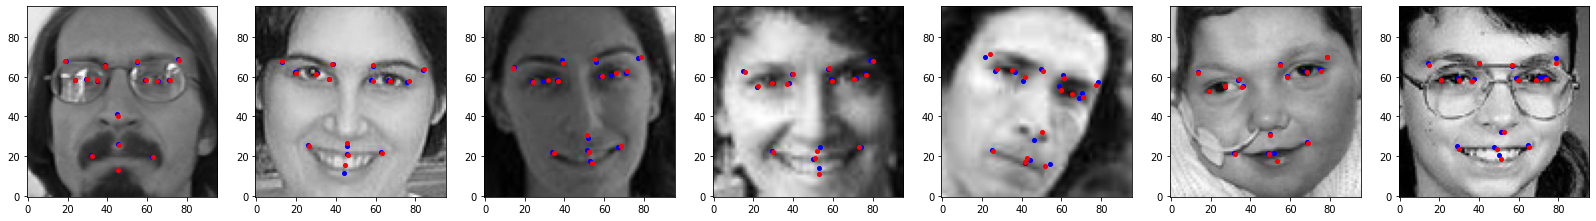

Note: Predicted points are red, and true labels are blue.


In [ ]:
## Evaluate Model on Semi-Supervised Dev Data.
print("Initial Model Evalutation on Semi-Supervised Dev Data.")

# Get scores.
dev_loss, dev_mae, dev_acc, dev_rmse = model.evaluate(sup_dev_data,
                                                      sup_dev_labels,
                                                      verbose=2)
# Print scores.
print("\nMean Absolute Error on Semi-Supervised Dev Data: %.3f"% (dev_mae))
print("Accuracy on Semi-Supervised Dev Data: %.3f"% (dev_acc))
print("Root Mean Squared Error on Semi-Supervised Dev Data: %.3f"% (dev_rmse))

# Generate & plot predictions.
dev_predictions = model.predict(sup_dev_data)
plot_predictions(sup_dev_data, sup_dev_labels, dev_predictions)

Initial Model Evalutation on Semi-Supervised Test Data.
33/33 - 0s - loss: 2.6412 - mae: 0.9606 - accuracy: 0.7426 - root_mean_squared_error: 1.6252 - 369ms/epoch - 11ms/step

Mean Absolute Error on Semi-Supervised Test Data: 0.961
Accuracy on Semi-Supervised Test Data: 0.743
Root Mean Squared Error on Semi-Supervised Test Data: 1.625


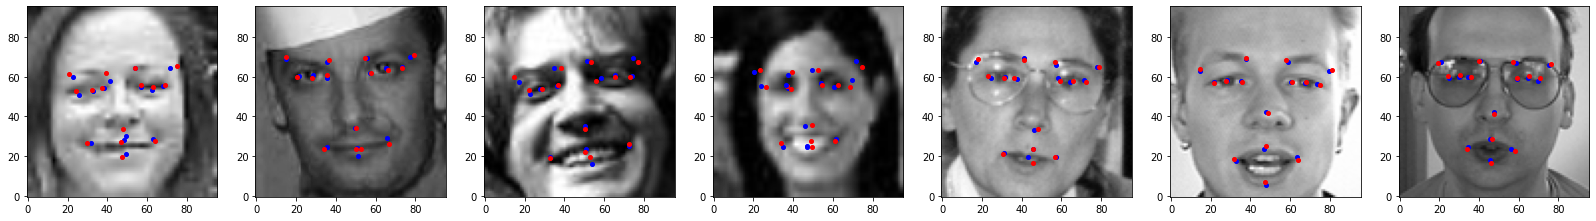

Note: Predicted points are red, and true labels are blue.


In [ ]:
## Evaluate Model on Semi-Supervised Test Data.
print("Initial Model Evalutation on Semi-Supervised Test Data.")

# Get scores.
test_loss, test_mae, \
test_acc, test_rmse = initial_model.evaluate(sup_test_data,
                                             sup_test_labels,
                                             verbose=2)
# Print scores.
print("\nMean Absolute Error on Semi-Supervised Test Data: %.3f"% (test_mae))
print("Accuracy on Semi-Supervised Test Data: %.3f"% (test_acc))
print("Root Mean Squared Error on Semi-Supervised Test Data: %.3f"% (test_rmse))

# Generate & plot predictions.
test_predictions = initial_model.predict(sup_test_data)
plot_predictions(sup_test_data, sup_test_labels, test_predictions)

Initial Model Evalutation on Perfect Test and Dev Data.
12/12 - 0s - loss: 0.4159 - mae: 0.4217 - accuracy: 0.9449 - root_mean_squared_error: 0.6449 - 201ms/epoch - 17ms/step

Mean Absolute Error on Perfect Evaluation Data: 0.422
Accuracy on Perfect Evaluation Data: 0.945
Root Mean Squared Error on Perfect Evaluation Data: 0.645


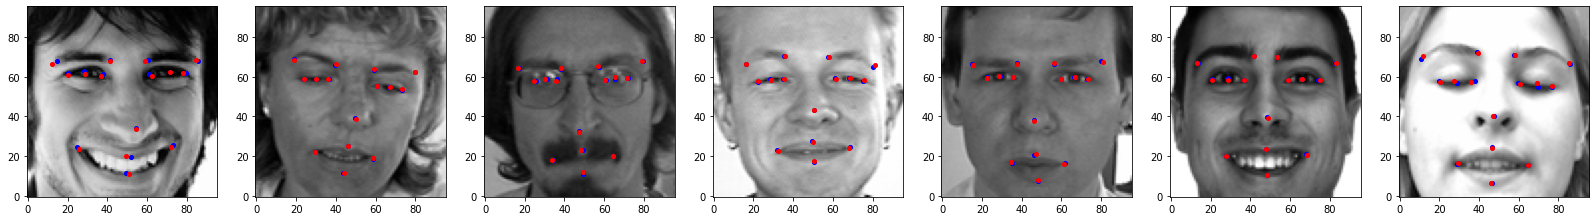

Note: Predicted points are red, and true labels are blue.


In [ ]:
## Evaluate Model on Perfect Test and Dev Data.
print("Initial Model Evalutation on Perfect Test and Dev Data.")

# Get scores.
perf_loss, perf_mae, \
perf_acc, perf_rmse = initial_model.evaluate(perf_eval_data,
                                             perf_eval_labels,
                                             verbose=2)
# Print scores.
print("\nMean Absolute Error on Perfect Evaluation Data: %.3f"% (perf_mae))
print("Accuracy on Perfect Evaluation Data: %.3f"% (perf_acc))
print("Root Mean Squared Error on Perfect Evaluation Data: %.3f"% (perf_rmse))

# Generate & plot predictions.
perf_eval_predictions = initial_model.predict(perf_eval_data)
plot_predictions(perf_eval_data, perf_eval_labels, perf_eval_predictions)

### 5.5 Retrain CNN Model.
**Using large batch size and only a few epochs...**

In [ ]:
# Load model.
new_model = tf.keras.models.load_model(checkpoint_path1)
checkpoint_path2 = "./drive/MyDrive/Model_15/Saved_Model_15/retrained_model_15_300epoch.hdf5"

checkpoint2 = ModelCheckpoint(filepath=checkpoint_path2,
                             save_weights_only=False,
                             save_best_only=True,
                             monitor="val_root_mean_squared_error",
                             mode="min",
                             verbose=1)

# Fit model.
history = new_model.fit(aug_train_data, aug_train_labels, 
          epochs=300, batch_size=512, 
          validation_data=(sup_test_data, sup_test_labels), 
          callbacks=[checkpoint2], 
          shuffle=True)

# Load the best retrained model.
retrained_model = tf.keras.models.load_model(checkpoint_path2)

Epoch 1/300
19/19 [==============================] - ETA: 0s - loss: 2.5097 - mae: 0.8000 - accuracy: 0.9142 - root_mean_squared_error: 1.5842
Epoch 00001: val_root_mean_squared_error improved from inf to 1.50160, saving model to ./drive/MyDrive/207_final/Model_15/Saved_Model_15/retrained_model_15_300epoch.hdf5
19/19 [==============================] - 6s 290ms/step - loss: 2.5097 - mae: 0.8000 - accuracy: 0.9142 - root_mean_squared_error: 1.5842 - val_loss: 2.2548 - val_mae: 0.7926 - val_accuracy: 0.7931 - val_root_mean_squared_error: 1.5016
Epoch 2/300
19/19 [==============================] - ETA: 0s - loss: 1.1777 - mae: 0.7615 - accuracy: 0.9125 - root_mean_squared_error: 1.0852
Epoch 00002: val_root_mean_squared_error improved from 1.50160 to 1.49077, saving model to ./drive/MyDrive/207_final/Model_15/Saved_Model_15/retrained_model_15_300epoch.hdf5
19/19 [==============================] - 5s 274ms/step - loss: 1.1777 - mae: 0.7615 - accuracy: 0.9125 - root_mean_squared_error: 1.085

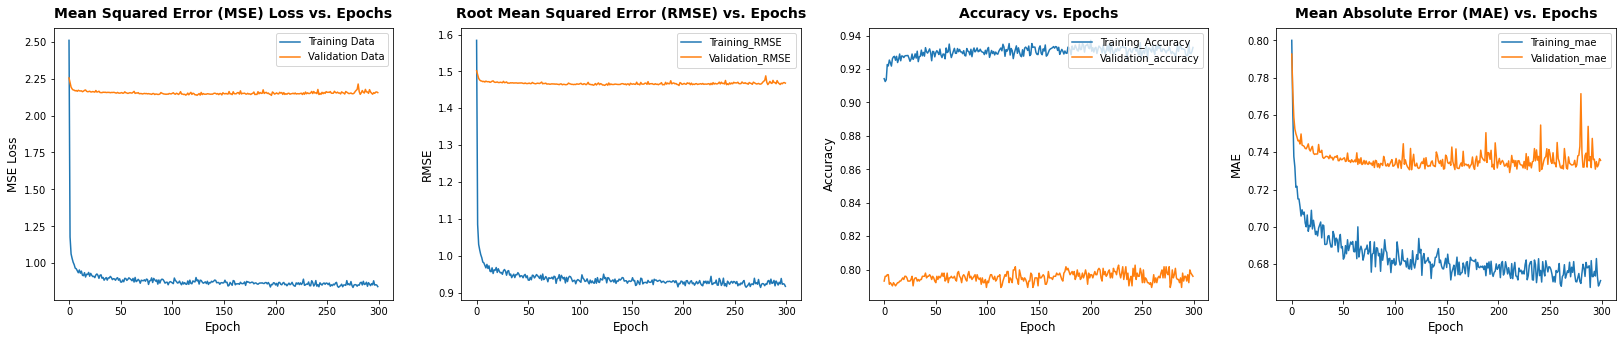

In [ ]:
# Plot metrics for each epoch.
plot_epochs(history)

### 5.6 Evaluate Best Retrained Model.

Retrained Model Evalutation on Semi-Supervised Dev Data.
4/4 - 0s - loss: 1.1887 - mae: 0.7286 - accuracy: 0.8100 - root_mean_squared_error: 1.0903 - 46ms/epoch - 11ms/step

Mean Absolute Error on Semi-Supervised Dev Data: 0.729
Accuracy on Semi-Supervised Dev Data: 0.810
Root Mean Squared Error on Semi-Supervised Dev Data: 1.090


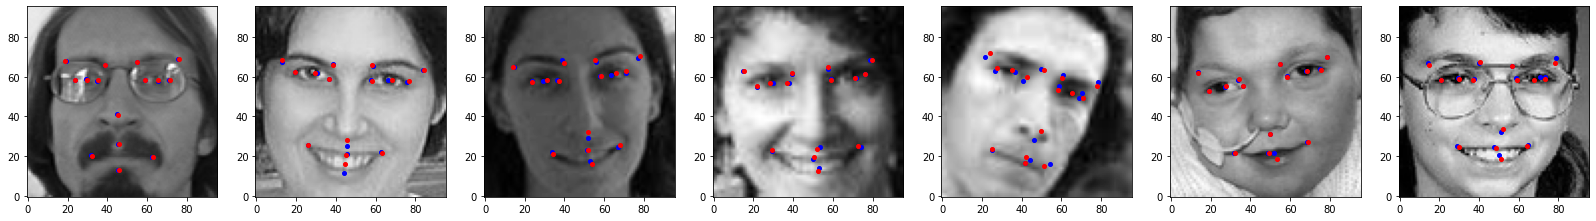

Note: Predicted points are red, and true labels are blue.


In [ ]:
## Evaluate Model on Semi-Supervised Dev Data.
print("Retrained Model Evalutation on Semi-Supervised Dev Data.")

# Get scores.
dev_loss, dev_mae, \
dev_acc, dev_rmse = retrained_model.evaluate(sup_dev_data,
                                             sup_dev_labels,
                                             verbose=2)
# Print scores.
print("\nMean Absolute Error on Semi-Supervised Dev Data: %.3f"% (dev_mae))
print("Accuracy on Semi-Supervised Dev Data: %.3f"% (dev_acc))
print("Root Mean Squared Error on Semi-Supervised Dev Data: %.3f"% (dev_rmse))

# Generate & plot predictions.
dev_predictions = retrained_model.predict(sup_dev_data)
plot_predictions(sup_dev_data, sup_dev_labels, dev_predictions)

Retrained Model Evalutation on Semi-Supervised Test Data.
33/33 - 0s - loss: 2.1366 - mae: 0.7309 - accuracy: 0.7969 - root_mean_squared_error: 1.4617 - 261ms/epoch - 8ms/step

Mean Absolute Error on Semi-Supervised Test Data: 0.731
Accuracy on Semi-Supervised Test Data: 0.797
Root Mean Squared Error on Semi-Supervised Test Data: 1.462


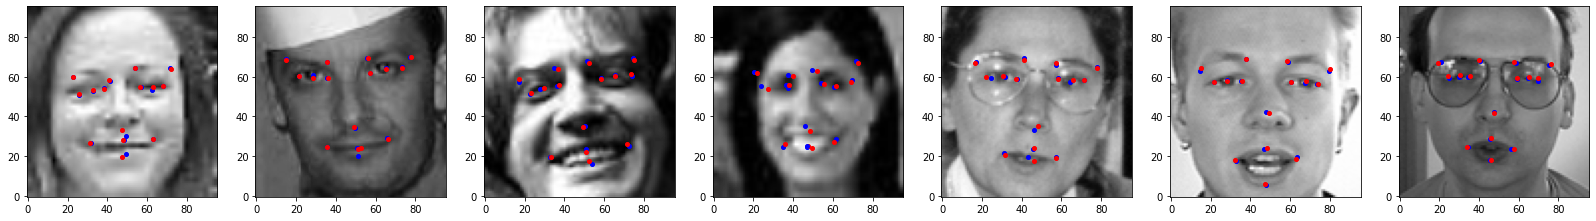

Note: Predicted points are red, and true labels are blue.


In [ ]:
## Evaluate Model on Semi-Supervised Test Data.
print("Retrained Model Evalutation on Semi-Supervised Test Data.")

# Get scores.
test_loss, test_mae, \
test_acc, test_rmse = retrained_model.evaluate(sup_test_data,
                                               sup_test_labels,
                                               verbose=2)
# Print scores.
print("\nMean Absolute Error on Semi-Supervised Test Data: %.3f"% (test_mae))
print("Accuracy on Semi-Supervised Test Data: %.3f"% (test_acc))
print("Root Mean Squared Error on Semi-Supervised Test Data: %.3f"% (test_rmse))

# Generate & plot predictions.
test_predictions = retrained_model.predict(sup_test_data)
plot_predictions(sup_test_data, sup_test_labels, test_predictions)

Retrained Model Evalutation on Perfect Test and Dev Data.
12/12 - 0s - loss: 0.3023 - mae: 0.2754 - accuracy: 0.9738 - root_mean_squared_error: 0.5498 - 104ms/epoch - 9ms/step

Mean Absolute Error on Perfect Evaluation Data: 0.275
Accuracy on Perfect Evaluation Data: 0.974
Root Mean Squared Error on Perfect Evaluation Data: 0.550


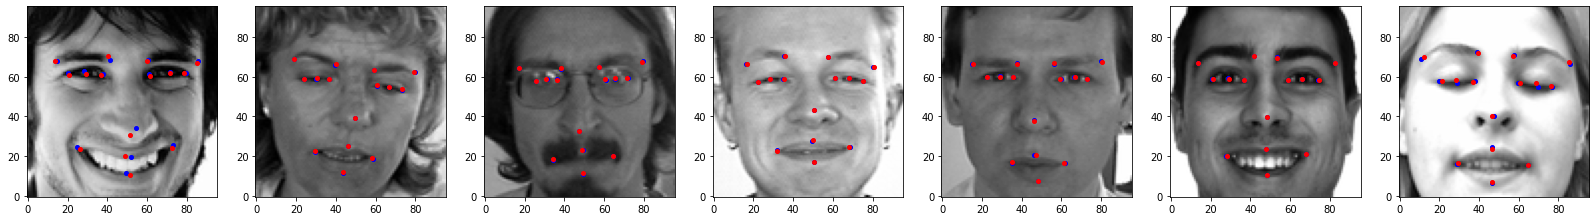

Note: Predicted points are red, and true labels are blue.


In [ ]:
## Evaluate Model on Perfect Test and Dev Data.
print("Retrained Model Evalutation on Perfect Test and Dev Data.")

# Get scores.
perf_loss, perf_mae, \
perf_acc, perf_rmse = retrained_model.evaluate(perf_eval_data, 
                                               perf_eval_labels,
                                               verbose=2)

# Print scores.
print("\nMean Absolute Error on Perfect Evaluation Data: %.3f"% (perf_mae))
print("Accuracy on Perfect Evaluation Data: %.3f"% (perf_acc))
print("Root Mean Squared Error on Perfect Evaluation Data: %.3f"% (perf_rmse))

# Generate & plot predictions.
perf_eval_predictions = retrained_model.predict(perf_eval_data)
plot_predictions(perf_eval_data, perf_eval_labels, perf_eval_predictions)

### 5.7 Generate Predictions for Final Test Data.

Retrained Model Predictions on Final Test Data:


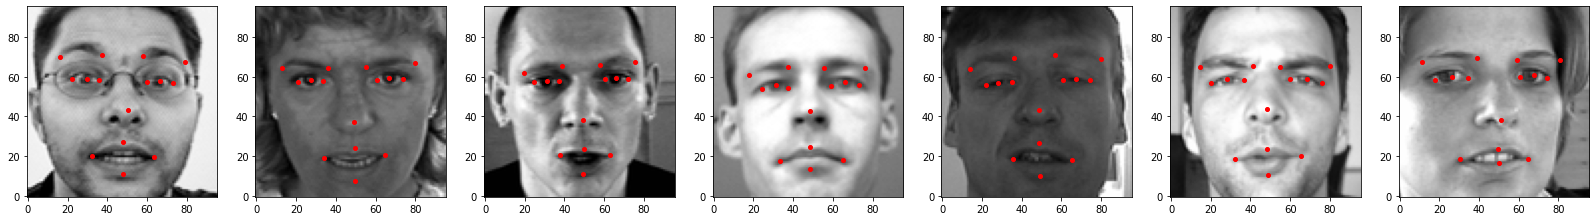

Note: Predicted points are red, and true labels are blue.


In [ ]:
## Generate & plot predictions for Kaggle submission.
print("Retrained Model Predictions on Final Test Data:")

# Generate predictions.
final_predictions = retrained_model.predict(X_test_final)

# Create new figure.
fig = plt.figure(figsize=(28,5))

# Plot images and true & predicted keypoints.
for i in range(7):
  plt.subplot(1,7,i+1)
  get_image_and_dots(i, X_test_final, 
                     predictions_ar=final_predictions)
plt.show()
print("Note: Predicted points are red, and true labels are blue.")
